In [1]:
import cv2
import os
import numpy as np
from tensorflow import keras
from keras import layers
from keras import models
from tensorflow.keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
import random,shutil
from keras.models import Sequential
from keras.layers import Dropout,Conv2D,Flatten,Dense, MaxPooling2D, BatchNormalization

# Reading all images from dataset and labeling them

In [4]:
Datadirectory = '../dataset/train'
Classes = ['closed', 'open']
training_data = []

In [15]:
def create_training_data():
    for category in Classes:
        path = os.path.join(Datadirectory, category)
        class_num = Classes.index(category)
        for img in os.listdir(path):
            try :
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                blackToRGB = cv2.cvtColor(img_array,cv2.COLOR_GRAY2RGB)
                #new_array = cv2.resize(backtorgb, (img_size,img_size))
                training_data.append([blackToRGB, class_num])
            except Exception as e:
                print(e)

In [16]:
create_training_data()

In [17]:
print(len(training_data))

3242


# Image processing

In [18]:
train_datagen = ImageDataGenerator(rescale=1./255)
#test_datagen = ImageDataGenerator(rescale=1./255)

In [43]:
train_dir = '../dataset/train'
img_size = 224
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(img_size, img_size),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 3242 images belonging to 2 classes.


In [44]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 224, 224, 3)
labels batch shape: (20,)


# model

In [45]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(img_size, img_size, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

## compile model

In [46]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

#     optimizer = Adam(0.0001)
#     model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

# new_model.compile(loss=keras.losses.BinaryCrossentropy(), optimizer = "adam", metrics = ["accuracy"])

In [47]:
history = model.fit(
      train_generator,
      steps_per_epoch=30, #100
      epochs=15) #30

Epoch 1/15
30/30 [==============================] - 26s 837ms/step - loss: 0.6763 - acc: 0.6031
Epoch 2/15
30/30 [==============================] - 25s 844ms/step - loss: 0.6463 - acc: 0.6426
Epoch 3/15
30/30 [==============================] - 26s 870ms/step - loss: 0.5805 - acc: 0.6850
Epoch 4/15
30/30 [==============================] - 26s 873ms/step - loss: 0.4976 - acc: 0.7483
Epoch 5/15
30/30 [==============================] - 26s 873ms/step - loss: 0.4404 - acc: 0.8317
Epoch 6/15
30/30 [==============================] - 27s 885ms/step - loss: 0.4087 - acc: 0.8517
Epoch 7/15
30/30 [==============================] - 25s 840ms/step - loss: 0.3518 - acc: 0.8986
Epoch 8/15
30/30 [==============================] - 26s 873ms/step - loss: 0.2888 - acc: 0.9183
Epoch 9/15
30/30 [==============================] - 27s 880ms/step - loss: 0.2736 - acc: 0.9183
Epoch 10/15
30/30 [==============================] - 27s 882ms/step - loss: 0.2503 - acc: 0.9167
Epoch 11/15
30/30 [====================

In [48]:
model.save('models/cnnBasic.h5', overwrite=True)

## plot acc

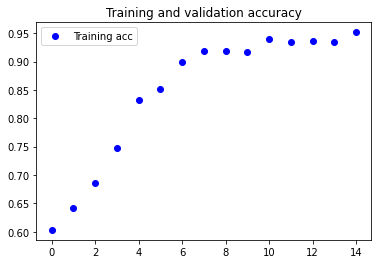

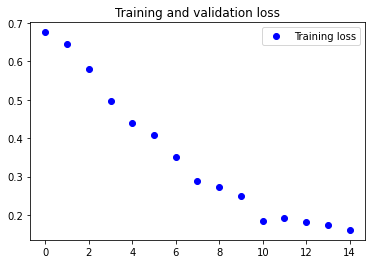

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['acc']
#val_acc = history.history['val_acc']
loss = history.history['loss']
#val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
#plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()